YOLO Model Prediction and Inference Pipeline

This notebook loads the trained YOLO model from notebook 03 and performs inference on test images from Pascal VOC 2012 dataset. Executes predictions with configurable confidence thresholds, visualizes detection results with bounding boxes, and provides per-class detection statistics.

Inference Workflow:
1. Load best-trained YOLO model (best.pt from notebook 03)
2. Configure inference parameters (confidence and IoU thresholds)
3. Execute predictions on test images from Pascal VOC 2012
4. Extract detection results (bounding boxes, class IDs, confidence scores)
5. Visualize predictions with bounding boxes overlay
6. Analyze per-class detection performance
7. Generate detection statistics and summaries

Dataset: Test split from Pascal VOC 2012 (~450-750 images)
Expected Runtime: 5-10 minutes on GPU, 30-60 minutes on CPU


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
from PIL import Image

# Paths
DATA_DIR = Path('../data')
MODELS_DIR = Path('../models')

# Best model candidates (try multiple locations)
best_model_candidates = [
    MODELS_DIR / 'best.pt',  # Copied location (preferred)
    Path('../runs/detect/yolo_run/weights/best.pt'),  # Default YOLO location
    MODELS_DIR / 'yolo_run' / 'weights' / 'best.pt',  # Old location
]

BEST_MODEL_PATH = None
for candidate in best_model_candidates:
    if candidate.exists():
        BEST_MODEL_PATH = candidate
        break

if not BEST_MODEL_PATH:
    print("ERROR: best.pt not found in expected locations:")
    for candidate in best_model_candidates:
        print(f"  - {candidate}")
    print("\nRun notebook 03_training.ipynb first to train the model")
    raise FileNotFoundError("Model file best.pt not found")

# Inference parameters
CONF_THRESHOLD = 0.5
IOU_THRESHOLD = 0.45

print("YOLO PREDICTION PIPELINE")
print("=" * 60)
print(f"Model: {BEST_MODEL_PATH}")
print(f"Confidence threshold: {CONF_THRESHOLD}")
print(f"IoU threshold: {IOU_THRESHOLD}")

# Load model
print("\nLoading model...")
model = YOLO(str(BEST_MODEL_PATH))
print("Model loaded successfully")
print("=" * 60)


YOLO PREDICTION PIPELINE
Model: ..\models\best.pt
Confidence threshold: 0.5
IoU threshold: 0.45

Loading model...
Model loaded successfully


Stage 1: Model Loading and Inference Configuration

This stage initializes the inference environment and loads the trained YOLO model for prediction.

Configuration parameters:
- CONF_THRESHOLD: Minimum confidence score for valid detections (0.5 = 50%)
- IOU_THRESHOLD: Intersection-over-Union threshold for non-maximum suppression (0.45)

Model loading:
- Loads best.pt from training (notebook 03)
- Requires notebook 03 to be executed first
- Raises FileNotFoundError if model not found

In [4]:
# Class mapping
CLASS_MAP = {0: 'person', 1: 'car', 2: 'dog'}

# Load test images
test_images_dir = DATA_DIR / 'images' / 'test'
test_images = sorted(test_images_dir.glob('*.jpg'))

print(f"\n[1] Batch Inference - {len(test_images)} test images")
print("-" * 60)

# Batch prediction on first 10 images
all_results = []
num_predict = min(10, len(test_images))

for img_path in test_images[:num_predict]:
    results = model.predict(
        source=str(img_path),
        conf=CONF_THRESHOLD,
        iou=IOU_THRESHOLD,
        verbose=False
    )
    
    result = results[0]
    detections_count = len(result.boxes) if result.boxes is not None else 0
    
    all_results.append({
        'image_path': img_path,
        'image_name': img_path.name,
        'detections_count': detections_count,
        'result': result
    })
    
    print(f"{img_path.name}: {detections_count} detections")

print(f"\nProcessed {len(all_results)} images")
print("=" * 60)


[1] Batch Inference - 435 test images
------------------------------------------------------------
test_0000.jpg: 0 detections
test_0001.jpg: 1 detections
test_0002.jpg: 1 detections
test_0003.jpg: 0 detections
test_0004.jpg: 0 detections
test_0005.jpg: 0 detections
test_0006.jpg: 0 detections
test_0007.jpg: 1 detections
test_0008.jpg: 1 detections
test_0009.jpg: 0 detections

Processed 10 images


Stage 2: Batch Inference on Test Images

This stage executes predictions on test dataset images and collects detection results.

Process:
1. Load all test images from data/images/test/ directory
2. For each image, run model.predict() with configured thresholds
3. Extract detection count and results from model output
4. Store results for analysis in subsequent stages

Output:
- all_results list containing predictions for each test image
- Each entry includes image path, filename, detection count, and raw YOLO output

In [5]:
# Analyze detections per class
class_stats = {cls: {'count': 0, 'confidences': []} for cls in CLASS_MAP.values()}

print("\n[2] Detection Analysis")
print("-" * 60)

for result_data in all_results:
    result = result_data['result']
    
    if result.boxes is not None:
        for box in result.boxes:
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = CLASS_MAP.get(class_id, 'unknown')
            
            if class_name in class_stats:
                class_stats[class_name]['count'] += 1
                class_stats[class_name]['confidences'].append(confidence)

# Print statistics
print("\nPer-Class Detection Statistics:")
total_detections = 0
for class_name, stats in class_stats.items():
    count = stats['count']
    total_detections += count
    
    if count > 0:
        avg_conf = np.mean(stats['confidences'])
        min_conf = np.min(stats['confidences'])
        max_conf = np.max(stats['confidences'])
        print(f"  {class_name}: {count} detections")
        print(f"    Confidence - avg: {avg_conf:.3f}, min: {min_conf:.3f}, max: {max_conf:.3f}")
    else:
        print(f"  {class_name}: 0 detections")

print(f"\nTotal detections: {total_detections}")
print("=" * 60)


[2] Detection Analysis
------------------------------------------------------------

Per-Class Detection Statistics:
  person: 1 detections
    Confidence - avg: 0.815, min: 0.815, max: 0.815
  car: 2 detections
    Confidence - avg: 0.781, min: 0.689, max: 0.872
  dog: 1 detections
    Confidence - avg: 0.751, min: 0.751, max: 0.751

Total detections: 4


Stage 3: Detection Analysis and Statistics

This stage aggregates predictions across all test images and computes per-class performance statistics.

Statistics computed:
- Detection count per class: Total number of objects detected for each class
- Confidence scores: Average, minimum, and maximum confidence per class

These metrics help evaluate:
- Whether model detects all object classes
- Relative confidence of different class predictions
- Quality and consistency of detections


[3] Prediction Visualization
------------------------------------------------------------


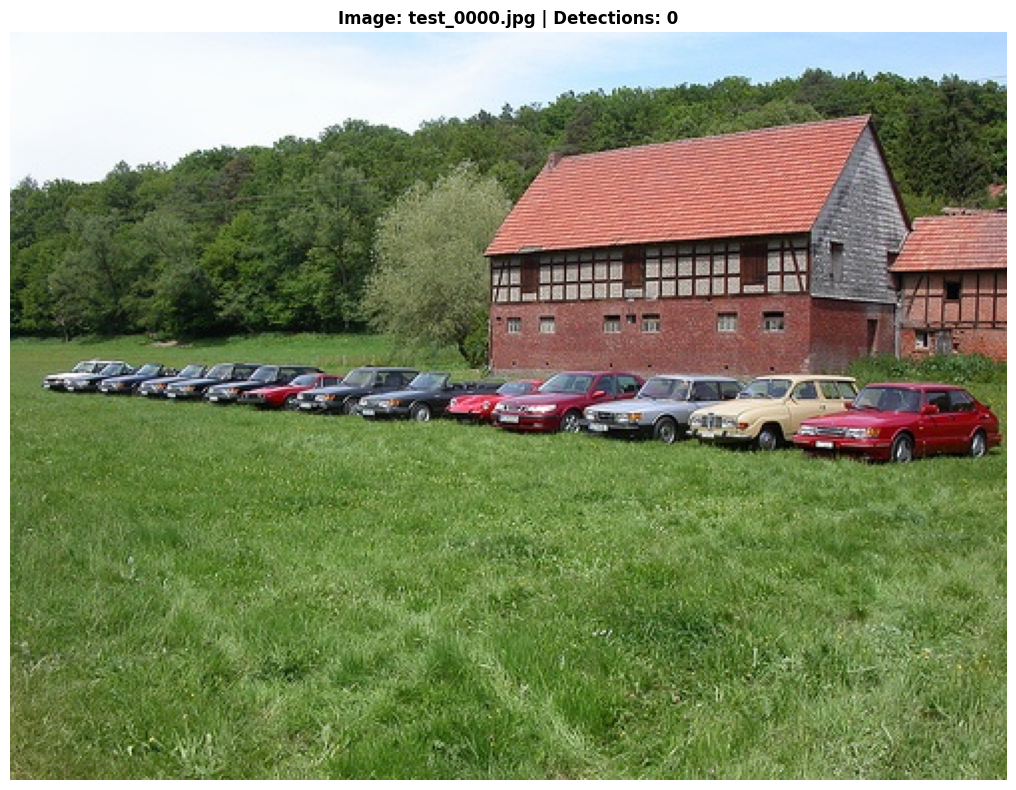


Image 1: test_0000.jpg


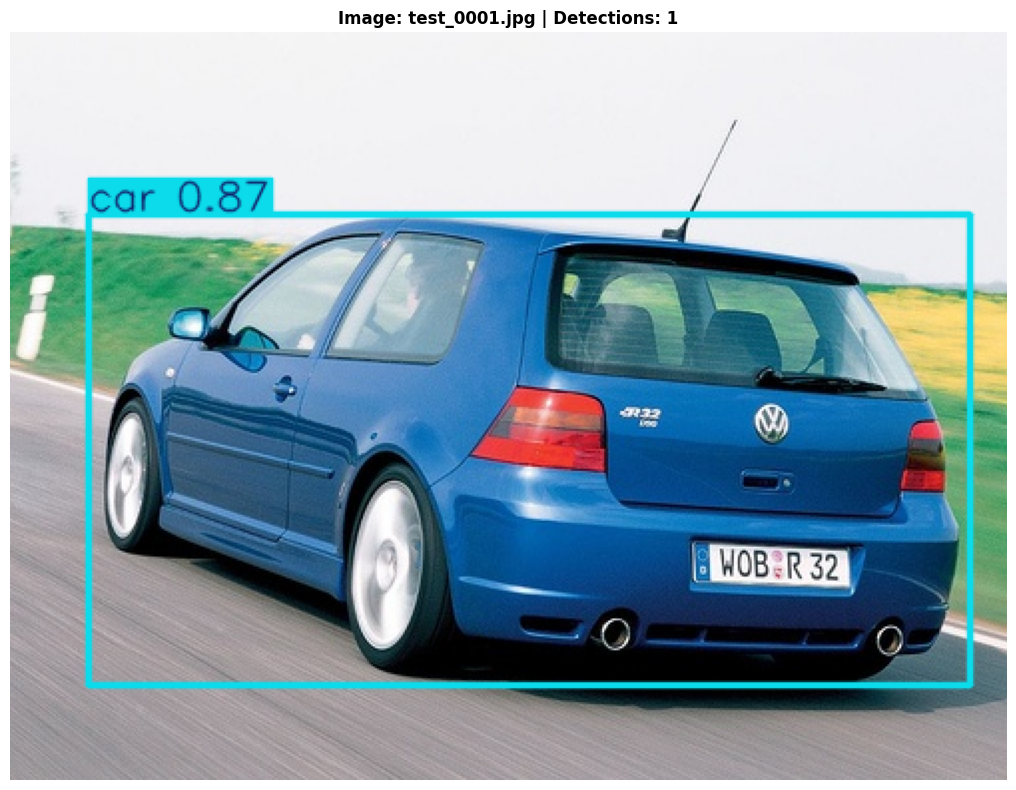


Image 2: test_0001.jpg
  Detection 1: car (confidence: 0.872)


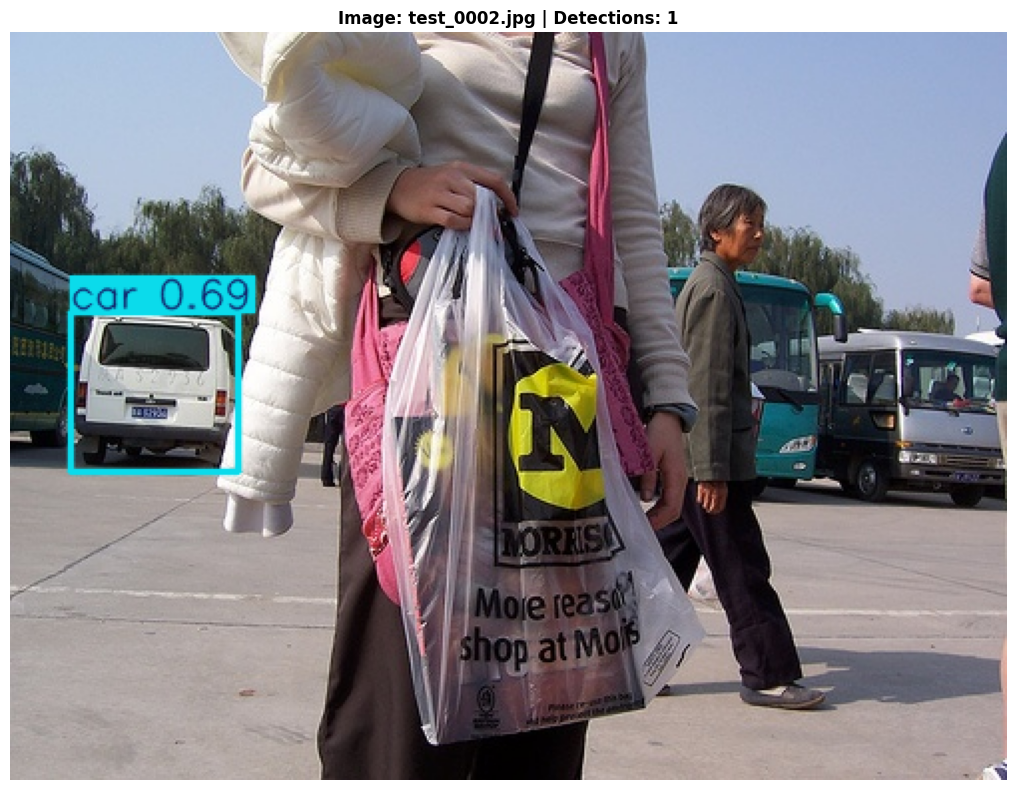


Image 3: test_0002.jpg
  Detection 1: car (confidence: 0.689)



In [6]:
# Visualize predictions with bounding boxes
print("\n[3] Prediction Visualization")
print("-" * 60)

num_visualize = min(3, len(all_results))

for idx in range(num_visualize):
    result_data = all_results[idx]
    result = result_data['result']
    
    # Load image
    img = Image.open(result_data['image_path'])
    
    # Get predictions
    pred_plot = result.plot()
    
    # Display
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(pred_plot[..., ::-1])  # Convert BGR to RGB
    ax.set_title(f"Image: {result_data['image_name']} | Detections: {result_data['detections_count']}", 
                 fontsize=12, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print detection details
    print(f"\nImage {idx+1}: {result_data['image_name']}")
    if result.boxes is not None:
        for i, box in enumerate(result.boxes):
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = CLASS_MAP.get(class_id, 'unknown')
            print(f"  Detection {i+1}: {class_name} (confidence: {confidence:.3f})")
    else:
        print("  No detections")

print("\n" + "=" * 60)

Stage 4: Prediction Visualization

This stage visualizes model predictions by overlaying bounding boxes on test images.

Visualization includes:
- Original image with detected bounding boxes drawn
- Class labels and confidence scores displayed
- Detection details printed for each object
- First 3 test images visualized using matplotlib

In [7]:
# Controlled prediction test - single image
print("\n[4] Controlled Prediction Test")
print("-" * 60)

if len(test_images) > 0:
    test_image = test_images[0]
    
    print(f"Test image: {test_image.name}")
    print(f"Path: {test_image}")
    
    # Single prediction
    result = model.predict(
        source=str(test_image),
        conf=CONF_THRESHOLD,
        iou=IOU_THRESHOLD,
        verbose=False
    )[0]
    
    print(f"\nResults:")
    print(f"  Image size: {result.orig_shape}")
    print(f"  Number of detections: {len(result.boxes) if result.boxes is not None else 0}")
    
    if result.boxes is not None:
        print(f"\n  Detailed predictions:")
        for i, box in enumerate(result.boxes):
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = CLASS_MAP.get(class_id, 'unknown')
            
            # Bounding box coordinates
            x1, y1, x2, y2 = [float(v) for v in box.xyxy[0]]
            
            print(f"    {i+1}. Class: {class_name}")
            print(f"       Confidence: {confidence:.4f}")
            print(f"       BBox: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")

print("\n✓ Inference pipeline completed")
print("=" * 60)


[4] Controlled Prediction Test
------------------------------------------------------------
Test image: test_0000.jpg
Path: ..\data\images\test\test_0000.jpg

Results:
  Image size: (375, 500)
  Number of detections: 0

  Detailed predictions:

✓ Inference pipeline completed


Stage 5: Controlled Prediction Test

This stage performs controlled, detailed prediction on a single test image for verification and debugging.

Output includes:
- Image metadata (size, path)
- Detailed prediction information for each detection:
  - Object class name
  - Confidence score
  - Bounding box coordinates in pixel space
- Verification that model is producing valid output format